In [48]:
# import the important libraries
import rasterio
import os
from rasterio import plot
from rasterio.mask import mask
from rasterio.merge import merge
from shapely.geometry import mapping
import matplotlib.pyplot as plt
import numpy as np 
import geopandas as gpd
%matplotlib inline

In [3]:
# เปิดไฟล์ภาพดาวเทียม landsat 8 
band4_050 = rasterio.open('band4/LC08_L2SP_129050_20240214_20240223_02_T1_SR_B4.TIF') #red
band5_050 = rasterio.open('band5/LC08_L2SP_129050_20240214_20240223_02_T1_SR_B5.TIF') #infra
band4_051 = rasterio.open('band4/LC08_L2SP_129051_20240214_20240223_02_T1_SR_B4.TIF') #red
band5_051 = rasterio.open('band5/LC08_L2SP_129051_20240214_20240223_02_T1_SR_B5.TIF') #infra

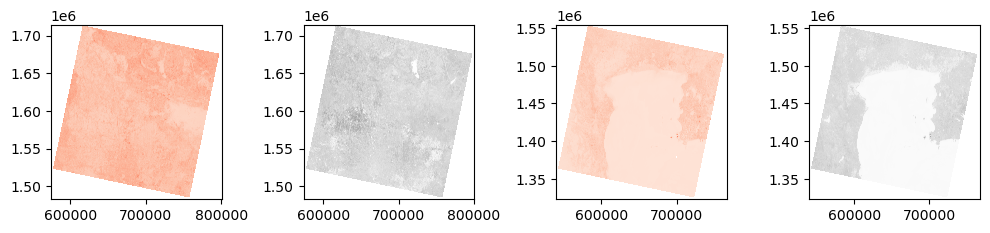

In [4]:
# เเสดงภาพดาวเทียม landsat 8
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(10, 6))
plot.show(band4_050, ax=ax1, cmap='Reds') #red
plot.show(band5_050, ax=ax2, cmap ='Greys') #nir
plot.show(band4_051, ax=ax3, cmap='Reds') #red
plot.show(band5_051, ax=ax4, cmap='Greys') #nir
fig.tight_layout()

In [4]:

# ขั้นตอนการต่อภาพ Mosaic 
# Define the directory containing the raster images

raster_band4_50_51 = 'band4'
raster_band5_50_51 = 'band5'


# List all raster files in the directory
raster_band4 = [os.path.join(raster_band4_50_51, f) for f in os.listdir(raster_band4_50_51) if f.endswith('.TIF')]

raster_band5 = [os.path.join(raster_band5_50_51, f) for f in os.listdir(raster_band5_50_51) if f.endswith('.TIF')]


# Open all the raster files
raster_band4_to_mosaic = [rasterio.open(f) for f in (raster_band4)]
raster_band5_to_mosaic = [rasterio.open(f) for f in (raster_band5)]
    

# Merge the rasters
mosaic_4, out_trans_4 = merge(raster_band4_to_mosaic)
mosaic_5, out_trans_5 = merge(raster_band5_to_mosaic)


# Copy the metadata from one of the input files
out_meta_band4 = raster_band4_to_mosaic[0].meta.copy()
out_meta_band5 = raster_band5_to_mosaic[0].meta.copy()

# Update the metadata with the new dimensions, transform, and CRS
out_meta_band4.update({
    "driver": "GTiff",
    "height": mosaic_4.shape[1],
    "width": mosaic_4.shape[2],
    "transform": out_trans_4,
    "crs": raster_band4_to_mosaic[0].crs
})

out_meta_band5.update({
    "driver": "GTiff",
    "height": mosaic_5.shape[1],
    "width": mosaic_5.shape[2],
    "transform": out_trans_5,
    "crs":raster_band5_to_mosaic[0].crs
})


# Write the mosaic to a new file
output_mosaic_band4 = 'band4_mosaic.tif'
with rasterio.open(output_mosaic_band4, "w", **out_meta_band4) as dest_4:
    dest_4.write(mosaic_4)

output_mosaic_band5 = 'band5_mosaic.tif'
with rasterio.open(output_mosaic_band5, "w", **out_meta_band5) as dest_5:
    dest_5.write(mosaic_5)



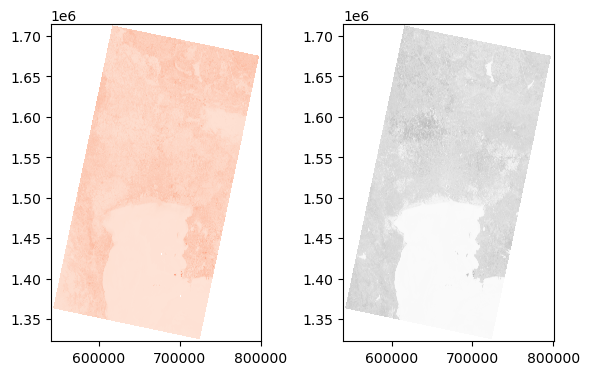

In [25]:
# เปิดภาพดาวเทียมที่ได้จากการต่อภาพ 
band4_mosaic = rasterio.open('band4_mosaic.tif')
band5_mosaic = rasterio.open('band5_mosaic.tif')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 6))
plot.show(band4_mosaic, ax=ax1, cmap = 'Reds') 
plot.show(band5_mosaic, ax=ax2, cmap = 'Greys') 
fig.tight_layout()


In [101]:
# ทำการคำนวณดัชนีพืชพันธ์ 
red = band4_mosaic.read(1).astype('float32')
nir = band5_mosaic.read(1).astype('float32')

In [ ]:
# ดัชนีพืชพันธ์จากสมการ
# เเต่เนื่องจากเกิดปัญหาในการอ่านค่าจากข้อมูลที่ได้จากการดาวเทียม มันหาค่า pixel value ในไฟล์ tiff ไม่เจอจึงออกมาเป็น nodata หมด เเต่นำไปเปิดในโปรเเกรม QGIS ปรากฎว่าเปิดได้ เเละมีค่า
# ดังนั้นเลยทำการคำนวณ NDVI ในโปรเเกรม QGIS โดยใช้สมการ NDVI เเละนำผลที่ได้มาใช้ในขั้นต่อไป

ndvi = np.where( 
    (nir + red) == 0. , 0 ,
    (nir - red) / (nir + red) 
)

ndvi

In [47]:
ndviImage = rasterio.open('ndviImage.tiff','w',driver='Gtiff',
                          width=band4_mosaic.width, 
                          height = band4_mosaic.height, 
                          count=1, crs=band4_mosaic.crs, 
                          transform=band4_mosaic.transform, 
                          dtype='float32')
ndviImage.write(ndvi,1)
ndviImage.close()

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 8671, 'height': 13051, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(30.0, 0.0, 540285.0,
       0.0, -30.0, 1714215.0)}


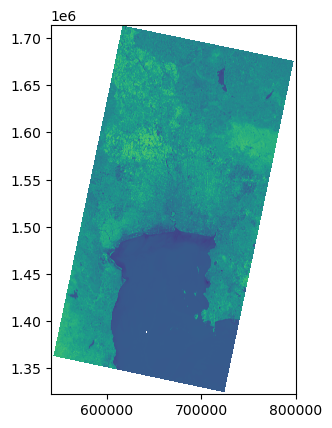

In [29]:
# เปิดภาพผล NDVI ที่ได้จากการคำนวณจากโปรเเกรม QGIS

with rasterio.open('NDVIimage.tif') as ndviImage :
    print(ndviImage.meta)
    plot.show(ndviImage, cmap = 'viridis')

In [122]:
#นำเข้า shp พื้นที่ในกรุงเทพมหานคร ในที่นี้เลือกเอาระดับเขตมาใช้
bkk_mask = gpd.read_file('D:\\Users\\Supanut\\thaicom\\thcomassignments\\bkk_district')
#bkk_mask_utm = bkk_mask.set_crs(epsg=32647, allow_override=True)

# Reproject the polygon to match the raster's CRS
polygon = bkk_mask.to_crs(ndviImage.crs)


EPSG:32647


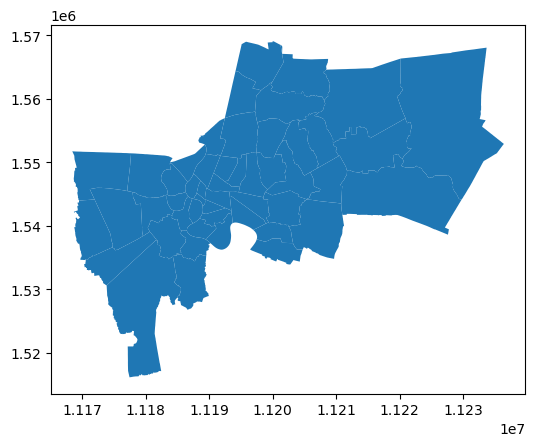

In [123]:
# เเสดงขอบเขตในพื้นที่กรุงเทพมหานคร
print(bkk_mask_utm.crs)
bkk_mask_utm.plot()
plt.show()

In [52]:
# ทำการเอาขอบเขต กรุงเทพมหานครมาตัดกับข้อมูล NDVI

#mask by bangkok boundary
# Convert the polygon to a GeoJSON-like format
shape = [mapping(geom) for geom in polygon.geometry]

with rasterio.open('NDVIimage.tif') as ndviImage_bkk:
    out_image, out_transform = mask(ndviImage_bkk, shape, crop=True)
    out_meta = ndviImage_bkk.meta

# Update metadata
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Save the clipped raster
with rasterio.open('ndvi_clip.tif', 'w', **out_meta) as dest:
    dest.write(out_image)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 2201, 'height': 1708, 'count': 1, 'crs': CRS.from_epsg(32647), 'transform': Affine(30.0, 0.0, 643515.0,
       0.0, -30.0, 1543365.0)}


c:\Users\HYDRO-3\anaconda3\Lib\site-packages\matplotlib\image.py:499: RuntimeWarning: overflow encountered in divide
  A_scaled /= ((a_max - a_min) / frac)


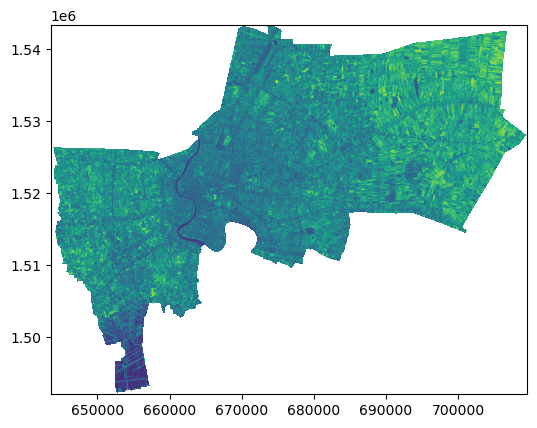

<bound method DatasetBase.close of <closed DatasetReader name='ndvi_clip.tif' mode='r'>>

In [96]:
# เเสดงผล NDVI ในพื้นที่กรุงเทพมหานคร
with rasterio.open('ndvi_clip.tif') as ndvi_bangkok :
    print(ndvi_bangkok.meta)
    plot.show(ndvi_bangkok) 
ndvi_bangkok.close



In [114]:

# Open the raster file
with rasterio.open('ndvi_clip.tif') as ndvi_bkk:
    
    # Read the first band of the raster
    band1 = ndvi_bkk.read(1)
    nodata_value = ndvi_bkk.nodata

# Mask out NoData values (usually represented by a specific value, often 0 or -9999)
# Here, assuming that NoData is represented by 0
masked_band1 = np.ma.masked_equal(band1, nodata_value)

# Calculate the average, excluding NoData values
average_value = masked_band1.mean()

print(f"The average value of the NDVI value is: {average_value}")



The average value of the NDVI value is: 0.1654492150243767


In [109]:
print( ' Area in Bangkok is:'  , np.sum(bkk_mask_utm.area), 'square meter')


 Area in Bangkok is: 1675535605.790304 square meter
